In [7]:
from pprint import pprint
from time import time
import numpy as np
import joblib

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, classification_report, ConfusionMatrixDisplay, precision_recall_curve, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher

import nltk
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt


In [2]:
df_train = pd.read_csv('../data/Ask0729-fixed.txt', sep='\t', header=None, names=["label", "text"])
df_test = pd.read_csv('../data/testSet-qualifiedBatch-fixed.txt', sep='\t', header=None, names=["label", "text"])

df_test.head()

,label,text
0,No,I look forward to meeting you and learning abo...
1,No,We look forward to seeing you next week!
2,No,A quick question before our meeting.
3,No,After sunning and drinking all day we feasted ...
4,No,"Also Tuesday, Kyle and Eric 1/2 hour."


In [3]:
df_train['target'] = df_train.apply(lambda r: 1 if r['label']=='Yes' else 0, axis=1)
df_test['target'] = df_test.apply(lambda r: 1 if r['label']=='Yes' else 0, axis=1)

In [3]:
df_train.head()

,label,text,target
0,No,>>> [1]Contact Me Now to Make $100 Today!$LINK,0
1,No,Act now to keep your life on the go!,0
2,No,Choose between $500 and $10000 dollars with up...,0
3,No,Click above to earn today.,0
4,No,Click here to receive your first $10 today:,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3657 non-null   object
 1   text    3657 non-null   object
 2   target  3657 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 85.8+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   992 non-null    object
 1   text    992 non-null    object
 2   target  992 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 23.4+ KB


In [6]:
df_train.isna().sum()

label     0
text      0
target    0
dtype: int64

In [7]:
df_train.label.value_counts()

label
No     1938
Yes    1719
Name: count, dtype: int64

In [8]:
1719/3657

0.4700574241181296

In [9]:
df_test.label.value_counts()

label
No     683
Yes    309
Name: count, dtype: int64

In [10]:
309/992

0.31149193548387094

The train set exhibits somewhat minor imbalance (47% emails labeled 'yes'), but the test set is a lot more imbalanced (31% 'yes'). As we work through this analysis, it will be important to keep in mind that a naive and useless heuristic predicting all 'No's on the test set would give us an accuracy of almost 69% !

## Bigram analysis

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/fanch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fanch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
ps = PorterStemmer()
 
sentence = "Do Programmers program with programming languages?"
words = word_tokenize(sentence)
bigrams = [words[i] + ' ' + words[i+1] for i in range(len(words)-1)]
print(bigrams)
 
# using reduce to apply stemmer to each word and join them back into a string
stemmed_sentence = reduce(lambda x, y: x + " " + ps.stem(y), words, "")
 
print(stemmed_sentence)

['Do Programmers', 'Programmers program', 'program with', 'with programming', 'programming languages', 'languages ?']
 do programm program with program languag ?


In [13]:
positiveValues=defaultdict(int)
negativeValues=defaultdict(int)

In [14]:
for txt in df_train[df_train.label=="Yes"].text:
    words = word_tokenize(txt)
    bigrams = [words[i] + ' ' + words[i+1] for i in range(len(words)-1) if words[i] not in set(stopwords.words('english'))]
    for b in bigrams:
        positiveValues[b] += 1

for txt in df_test[df_test.label=="No"].text:
    words = word_tokenize(txt)
    bigrams = [words[i] + ' ' + words[i+1] for i in range(len(words)-1) if words[i] not in set(stopwords.words('english'))]
    for b in bigrams:
        negativeValues[b] += 1

In [15]:
positiveValues

defaultdict(int,
            {'-If you': 2,
             'want others': 1,
             'others to': 1,
             'help manage': 1,
             'manage your': 4,
             'channel ,': 1,
             ', you': 33,
             'add up': 1,
             '50 people': 1,
             'people without': 1,
             'without sharing': 1,
             'sharing your': 1,
             'password .': 3,
             '3 .': 4,
             '. Select': 1,
             'Select the': 2,
             'services that': 1,
             'want to': 90,
             'add .': 1,
             'Also want': 1,
             'talk about': 11,
             'voicemail last': 1,
             'last night': 3,
             'night --': 1,
             '-- i.e.': 1,
             'i.e. ,': 2,
             ', I': 73,
             'I may': 5,
             'may need': 4,
             'need to': 64,
             'travel with': 1,
             'KL ,': 1,
             ', which': 5,
             'fine by': 1,
       

In [16]:
df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))

In [17]:
df_positive[:30]

,0,1
0,", please",158
1,If you,110
2,like to,106
3,want to,90
4,would like,75
5,", I",73
6,need to,64
7,I would,59
8,let me,51
9,$ LINK,50


In [18]:
df_negative[:30]

,0,1
0,", and",53
1,", I",45
2,I am,41
3,I will,37
4,I have,35
5,", but",33
6,week .,33
7,I 'm,32
8,next week,25
9,", so",25


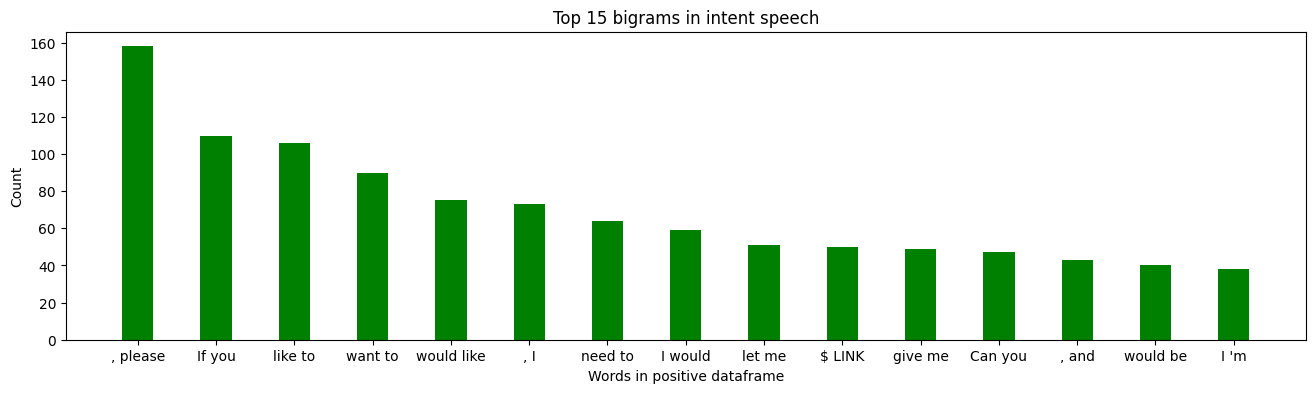

In [19]:
yes_txt   = df_positive[0][:15]
yes_count = df_positive[1][:15]

plt.figure(1,figsize=(16,4))
plt.bar(yes_txt,yes_count, color ='green', width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 15 bigrams in intent speech")
plt.show()

In [20]:
df_positive[-15:]

,0,1
10262,yet got,1
10263,review us,1
10264,"Appstore ,",1
10265,request you,1
10266,us spread,1
10267,spread awareness,1
10268,awareness among,1
10269,among more,1
10270,consumers and,1
10271,businesses like,1


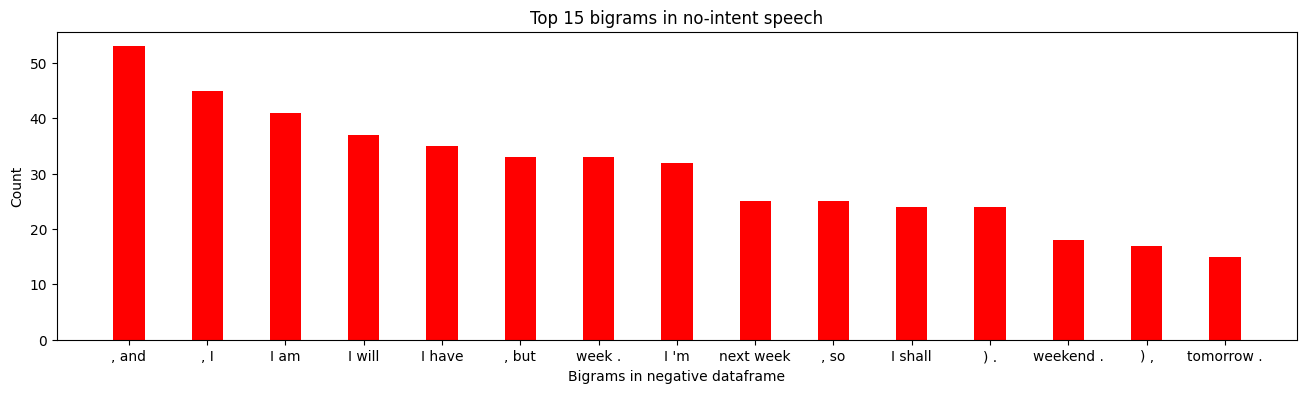

In [21]:
no_txt   = df_negative[0][:15]
no_count = df_negative[1][:15]

plt.figure(1,figsize=(16,4))
plt.bar(no_txt,no_count, color ='red', width = 0.4)
plt.xlabel("Bigrams in negative dataframe")
plt.ylabel("Count")
plt.title("Top 15 bigrams in no-intent speech")
plt.show()

In [22]:
df_negative[-15:]

,0,1
6038,things next,1
6039,Your December,1
6040,December 2001,1
6041,2001 issue,1
6042,issue of,1
6043,E-lert for,1
6044,personal development,1
6045,development in,1
6046,business is,1
6047,: //www.BusinessCafeOnline.com,1


## First model: Complement Naive Bayes on TF-IDF matrix

In [23]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [24]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In [25]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [26]:
t0 = time()
random_search.fit(df_train.text, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Done in 9.811s


In [27]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 1.0
vect__max_df: 0.6
vect__min_df: 3
vect__ngram_range: (1, 2)
vect__norm: l1


In [28]:
test_accuracy = random_search.score(df_test.text, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.732
Accuracy on test set: 0.785


## Improved model: Support Vector Machine on TF-IDF matrix

In [29]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("rbf_svm", SVC()),
    ]
)

#pipeline

parameter_grid = {
        "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        "vect__min_df": (1, 3, 5, 10),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__norm": ("l1", "l2"),
        'rbf_svm__C': [1, 10, 100, 1000], 
        'rbf_svm__gamma': [0.001, 0.0001, 'scale'], 
        'rbf_svm__kernel': ['rbf', 'linear', 'poly'],
        'rbf_svm__class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'rbf_svm__C': [1, 10, 100, 1000],
 'rbf_svm__class_weight': ['balanced', None],
 'rbf_svm__gamma': [0.001, 0.0001, 'scale'],
 'rbf_svm__kernel': ['rbf', 'linear', 'poly'],
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [30]:
t0 = time()
random_search.fit(df_train.text, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Done in 510.921s


In [31]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
rbf_svm__C: 1
rbf_svm__class_weight: balanced
rbf_svm__gamma: scale
rbf_svm__kernel: rbf
vect__max_df: 0.4
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l2


In [32]:
test_accuracy = random_search.score(df_test.text, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.756
Accuracy on test set: 0.826


              precision    recall  f1-score   support

           0       0.90      0.84      0.87       683
           1       0.69      0.79      0.74       309

    accuracy                           0.83       992
   macro avg       0.80      0.82      0.80       992
weighted avg       0.84      0.83      0.83       992



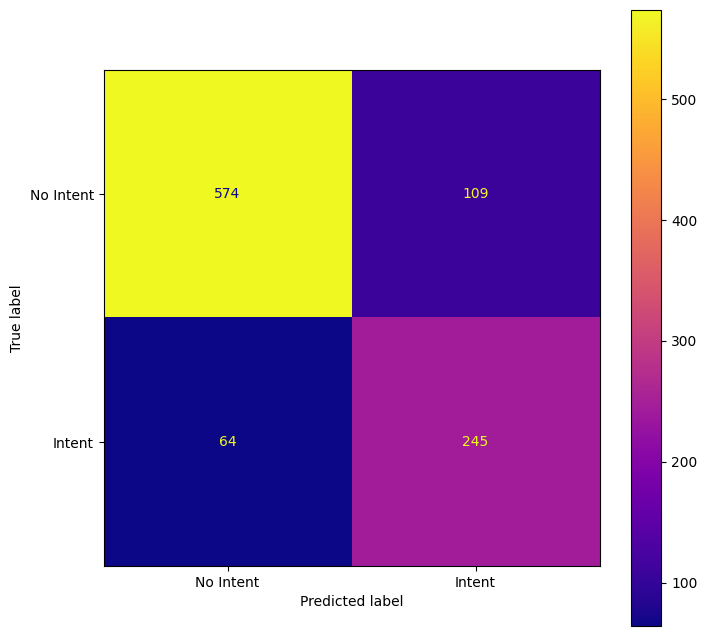

In [33]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './best_model.pkl')
# Loading the best model
load_model = joblib.load('./best_model.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(df_test.text)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, df_test.text, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)

In [34]:
(245+574)/992

0.8256048387096774

Quoting the Parakweet wiki page:

With LibSVM on the selected n-gram feature vectors we have provided:

- Precision: 71.9%
- Recall: 78.5%
- F1: 71.2%
- Accuracy: 79.0%

With LibSVM on feature vectors that combine n-grams and proprietary ActivityRelation signal (not in feature files provided):

- Precision: 77.3%
- Recall: 78.3%
- F1: 77.8%
- Accuracy: 86.0%

Our model achieves better precision, recall and F1 than their best model, while having a precision that sits 3 points below theirs. 
It would be good to have access to their perf metrics at the class level, because it's not obvious to me how their accuracy can be so high given their precision and recall.

## SGD Classifier

We do this to have access to reliable probabilities (SVC implem does not guarantee they are reliable), and visualize a ROC curve.


In [35]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("sgd", SGDClassifier()),
    ]
)

#pipeline

parameter_grid = {
        "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        "vect__min_df": (1, 3, 5, 10),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__norm": ("l1", "l2"),
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'], 
        'sgd__class_weight' : ['balanced', None],
        'sgd__penalty': ['l2', 'l1']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'sgd__class_weight': ['balanced', None],
 'sgd__loss': ['hinge',
               'log_loss',
               'modified_huber',
               'squared_hinge',
               'perceptron'],
 'sgd__penalty': ['l2', 'l1'],
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [36]:
t0 = time()
random_search.fit(df_train.text, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before

Done in 26.160s


In [37]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
sgd__class_weight: balanced
sgd__loss: log_loss
sgd__penalty: l2
vect__max_df: 1.0
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l2


In [38]:
test_accuracy = random_search.score(df_test.text, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.752
Accuracy on test set: 0.821


              precision    recall  f1-score   support

           0       0.92      0.81      0.86       683
           1       0.67      0.85      0.75       309

    accuracy                           0.82       992
   macro avg       0.79      0.83      0.80       992
weighted avg       0.84      0.82      0.83       992



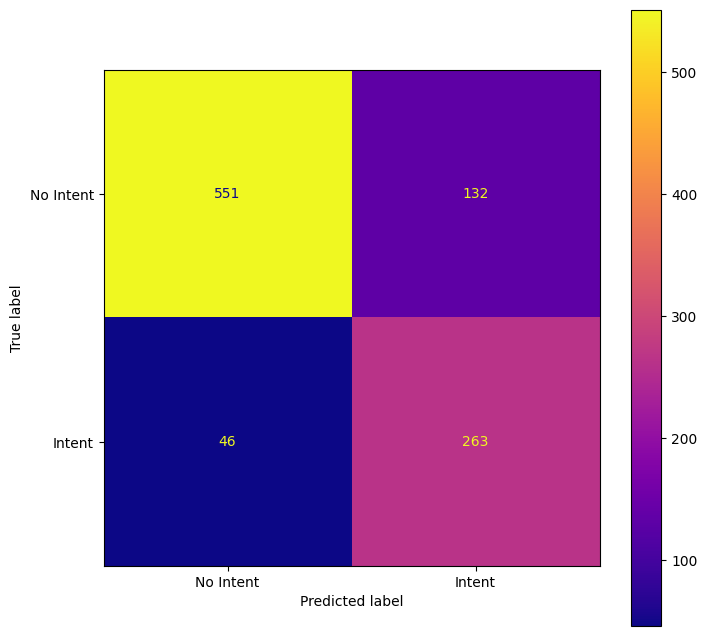

In [39]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './sgd_model.pkl')
# Loading the best model
load_model = joblib.load('./sgd_model.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(df_test.text)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, df_test.text, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)

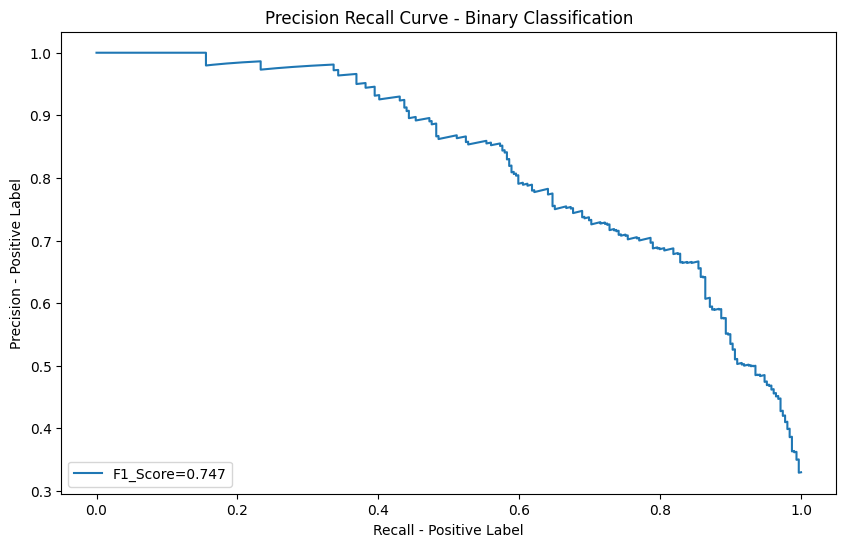

In [40]:
y_prob=best_clf_pipe.predict_proba(df_test.text)

precision,recall,thresholds = precision_recall_curve(df_test.target,y_prob[:,1])
plt.figure(figsize=(10,6))
plt.plot(recall,precision,label='F1_Score={0:0.3f}'.format(f1_score(df_test.target, y_pred,average='binary',pos_label=1)))
plt.xlabel('Recall - Positive Label')
plt.ylabel('Precision - Positive Label')
plt.title('Precision Recall Curve - Binary Classification')
plt.legend(loc='lower left')
plt.show()

## Ensemble

In [41]:
estimators = []
estimators.append(('logistic', LogisticRegression()))
estimators.append(('cart', DecisionTreeClassifier()))
estimators.append(('svm', SVC()))

# Create the Ensemble Model
ensemble = VotingClassifier(estimators)

# Make preprocess Pipeline
pipe = Pipeline([
    ("vect", TfidfVectorizer()),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),  # Min Max Scaler
    ('model', ensemble)  # Ensemble Model
])

In [42]:
parameter_grid = {
        "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        "vect__min_df": (1, 3, 5, 10),
        "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        "vect__norm": ("l1", "l2"),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [43]:
t0 = time()
random_search.fit(df_train.text, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Done in 16.790s


In [44]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
vect__max_df: 0.4
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l2


In [45]:
test_accuracy = random_search.score(df_test.text, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.748
Accuracy on test set: 0.766


              precision    recall  f1-score   support

           0       0.89      0.76      0.82       683
           1       0.59      0.79      0.68       309

    accuracy                           0.77       992
   macro avg       0.74      0.77      0.75       992
weighted avg       0.80      0.77      0.77       992



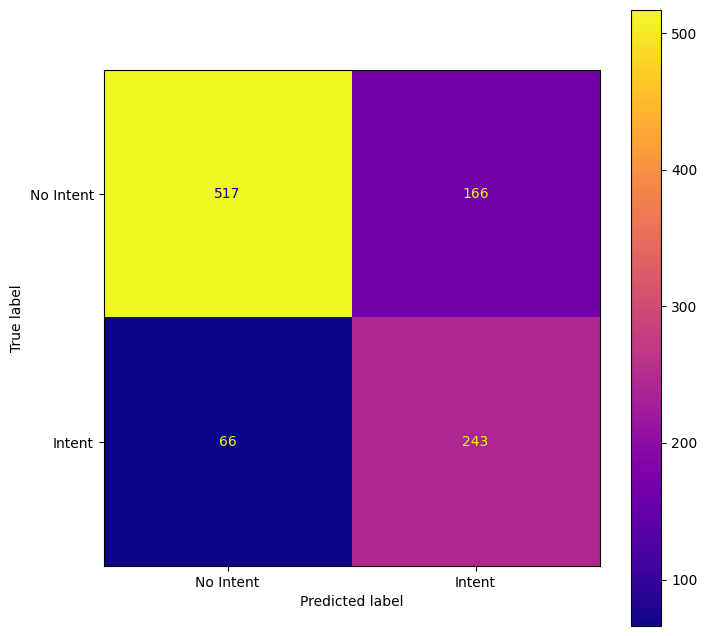

In [47]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './ensemble_model.pkl')
# Loading the best model
load_model = joblib.load('./ensemble_model.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(df_test.text)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, df_test.text, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)

## Feature Hashing

In [48]:
def tokenize(txt):
    words = word_tokenize(txt)
    return [words[i] + ' ' + words[i+1] for i in range(len(words)-1) if words[i] not in set(stopwords.words('english'))]

df_train['bigrams'] = df_train.apply(lambda r: tokenize(r['text']), axis=1)

h = FeatureHasher(n_features=2**18, input_type='string')
h_train = h.transform(df_train.bigrams)

pipeline = Pipeline(
    [
        ("sgd", SGDClassifier()),
    ]
)

parameter_grid = {
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'], 
        'sgd__class_weight' : ['balanced'],
        'sgd__penalty': ['l2', 'l1']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'sgd__class_weight': ['balanced'],
 'sgd__loss': ['hinge',
               'log_loss',
               'modified_huber',
               'squared_hinge',
               'perceptron'],
 'sgd__penalty': ['l2', 'l1']}


In [49]:
from time import time

t0 = time()
random_search.fit(h_train, df_train.target)
print(f"Done in {time() - t0:.3f}s")

/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Done in 0.497s


In [50]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
sgd__class_weight: balanced
sgd__loss: log_loss
sgd__penalty: l2


In [51]:
df_test['bigrams'] = df_test.apply(lambda r: tokenize(r['text']), axis=1)

# h = FeatureHasher(n_features=2**18, input_type='string')
h_test = h.transform(df_test.bigrams)

In [52]:
test_accuracy = random_search.score(h_test, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.678
Accuracy on test set: 0.736


              precision    recall  f1-score   support

           0       0.85      0.75      0.80       683
           1       0.56      0.71      0.62       309

    accuracy                           0.74       992
   macro avg       0.70      0.73      0.71       992
weighted avg       0.76      0.74      0.74       992



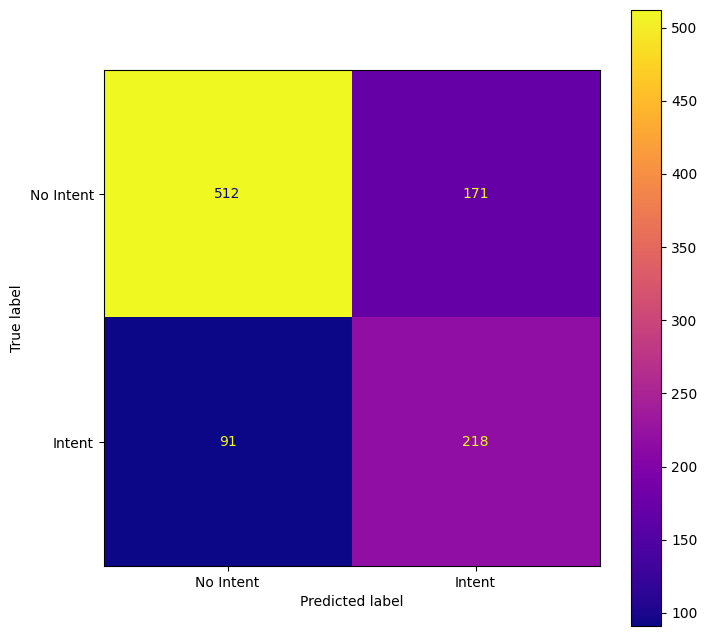

In [54]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './hash_model.pkl')
# Loading the best model
load_model = joblib.load('./hash_model.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(h_test)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, h_test, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)

## Zero-shot prompting with Mistral Orca 7B

We put together a custom system prompt and inference script to use one of the best performing LLM: Mistral 7B, fine-tuned on Orca instructions dataset. 

See script `mistral-orca.py` for the actual execution that is making use of the Replicate API, and Nate Raw's model.

The resulting outputs are persisted in file 'mistral_output.txt', which we use below to evaluate the performance of this approach:

In [56]:
df_test = pd.read_csv('../data/testSet-qualifiedBatch-fixed.txt', sep='\t', header=None, names=["label", "text"])
df_test['target'] = df_test.apply(lambda r: 1 if r['label']=='Yes' else 0, axis=1)


with open('mistral_output.txt','r') as f:
    mistral_answers = f.readlines()

preds = []
for rec in mistral_answers:
    rec = rec.strip('\n')
    text = rec[:-8]
    label = rec[-1:]
    print(text, label)
    preds.append(int(label))

preds_df = pd.DataFrame({"preds":preds})
preds_df.to_parquet("../data/mistral_predictions.pq")

I look forward to meeting you and learning about your successful business.  0
We look forward to seeing you next week!  0
A quick question before our meeting.  1
After sunning and drinking all day we feasted on a fleisch dinner...that was all we had here to eat, so we grilled bauchfleisch, steaks and bratw?rst...WE ATE SOOO MUCH, but we had DRANK SO MUCH THAT WE NEEDED IT, good greasy stuff.  0
Also Tuesday, Kyle and Eric 1/2 hour.  0
Also, I made a change to paragraph 7 to include technical bulletins per Mitch's request which we did not discuss on our call.  1
As i was pondering the meeting last night going home in my car, I realized that I forgot to talk about 2 people, including regulatory and your personal efforts.  1
As you become the responsible lawyer, first in Mexico, and maybe in the rest of South America, you may have a different opinion on these issues and we can certainly change our policies at any time.  1
As you know, last year's congress attracted over 200 attendees and 

In [57]:

print(classification_report(df_test.target,preds))

              precision    recall  f1-score   support

           0       0.88      0.41      0.56       683
           1       0.40      0.88      0.55       309

    accuracy                           0.55       992
   macro avg       0.64      0.64      0.55       992
weighted avg       0.73      0.55      0.55       992



Yeesh, that is not very good. As a matter of fact it is even worse than the naive heuristic.

## Embeddings approach

In [8]:
emb_train = pd.read_parquet('../data/train_embeddings.pq')
emb_test = pd.read_parquet('../data/test_embeddings.pq')

In [10]:
pipeline = Pipeline(
    [
        ("rbf_svm", SVC()),
    ]
)

#pipeline

parameter_grid = {
        'rbf_svm__C': [1, 10, 100, 1000], 
        'rbf_svm__gamma': [0.001, 0.0001, 'scale'], 
        'rbf_svm__kernel': ['rbf', 'linear', 'poly'],
        'rbf_svm__class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'rbf_svm__C': [1, 10, 100, 1000],
 'rbf_svm__class_weight': ['balanced', None],
 'rbf_svm__gamma': [0.001, 0.0001, 'scale'],
 'rbf_svm__kernel': ['rbf', 'linear', 'poly']}


In [11]:
t0 = time()
random_search.fit(emb_train, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py

Done in 1019.306s


In [12]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
rbf_svm__C: 1
rbf_svm__class_weight: balanced
rbf_svm__gamma: scale
rbf_svm__kernel: rbf


In [13]:
test_accuracy = random_search.score(emb_test, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Accuracy of the best parameters using the inner CV of the random search: 0.754
Accuracy on test set: 0.786


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


              precision    recall  f1-score   support

           0       0.91      0.76      0.83       683
           1       0.62      0.83      0.71       309

    accuracy                           0.79       992
   macro avg       0.76      0.80      0.77       992
weighted avg       0.82      0.79      0.79       992



/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:753: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:591: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/utils/validation.py:600: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


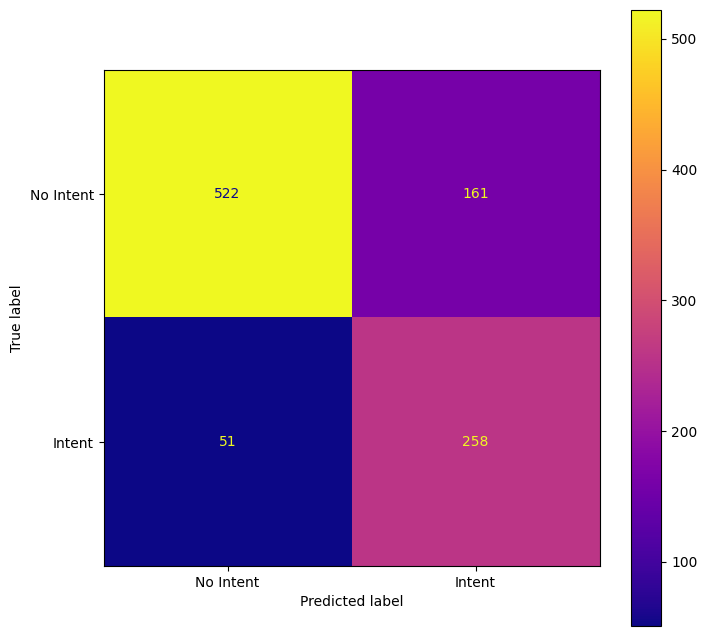

In [15]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './embedding_model.pkl')
# Loading the best model
load_model = joblib.load('./embedding_model.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(emb_test)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, emb_test, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)

In [16]:
import xgboost as xgb

pipeline = Pipeline(
    [
        ("model", xgb.XGBClassifier()),
    ]
)

parameter_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=100,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'model__max_depth': [2, 3, 5, 7, 10], 'model__n_estimators': [10, 100, 500]}


In [17]:
t0 = time()
random_search.fit(emb_train, df_train.target)
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a fut

Done in 180.484s


In [18]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
model__max_depth: 5
model__n_estimators: 500


In [19]:
test_accuracy = random_search.score(emb_test, df_test.target)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.736
Accuracy on test set: 0.758


/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       683
           1       0.58      0.80      0.67       309

    accuracy                           0.76       992
   macro avg       0.74      0.77      0.74       992
weighted avg       0.79      0.76      0.77       992



/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/fanch/.pyenv/versions/3.9.17/envs/bluecargo/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

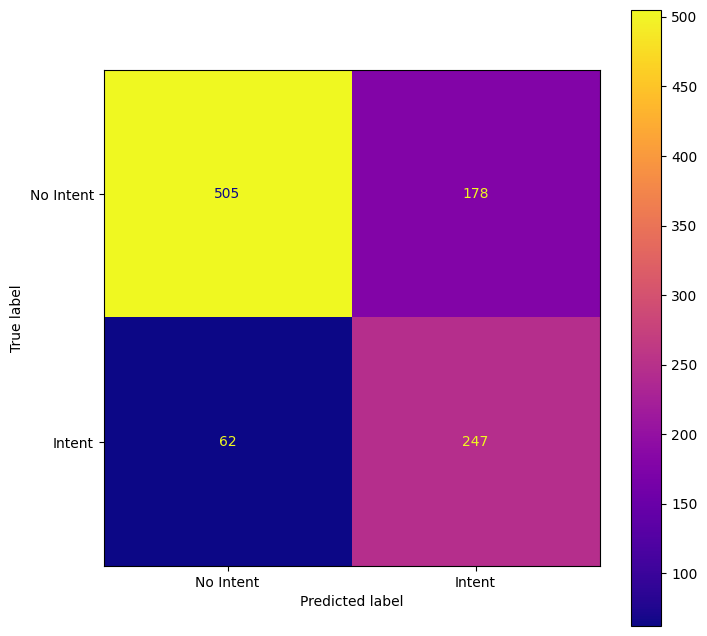

In [20]:
# Saving the best model
joblib.dump(random_search.best_estimator_, './embedding_model_xg.pkl')
# Loading the best model
load_model = joblib.load('./embedding_model_xg.pkl')
best_clf_pipe=load_model
# Predicting the class
y_pred=best_clf_pipe.predict(emb_test)
# Classification Report
print(classification_report(df_test.target,y_pred))
# Confusion Matrix
fig, axs = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_clf_pipe, emb_test, 
                                      df_test.target, values_format='d',
                                      display_labels=['No Intent','Intent'],
                                      cmap='plasma', ax=axs)